In [24]:
try:
    from google.colab import auth
    from google.colab import drive

    auth.authenticate_user()
    print('Authenticated')
    drive.mount('/content/drive')

    !pip install -q tensorflow-recommenders
    !pip install -q scann
    IN_COLAB = True
except:
    IN_COLAB = False

Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from typing import Dict, Text
import os

from google.cloud import bigquery
from google.cloud.bigquery_storage_v1beta1 import BigQueryStorageClient
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

# Dataset
We use the interaction between user ans product for user that has at least 2 orders to build a model

In [3]:
MINIMUM_PRODUCTS = 5
MINIMUM_ORDERS = 2
data_project_id = "peya-food-and-groceries"
data_dataset_id = "user_fiorella_dirosario"
data_table_orders = "order_sep2020_sep2021"
data_table_order_details = "order_details_sep2020_sep2021"
data_table_users = "attributes_sep2020_sep2021"
data_table_products = "product_attributes_sep2020_sep2021"

interaction_query_train = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    uo.user_id
  , EXTRACT(DAYOFWEEK FROM uo.timestamp) as dow
  , EXTRACT(hour FROM uo.timestamp) as hod
  , od.gtin
  , IF(od.partner_id IS NULL, -1, od.partner_id) AS partner_id
  , IF(pa.category_id IS NULL, -1, pa.category_id) AS category_id
  , IF(pa.brand_id IS NULL, -1, pa.brand_id) AS brand_id
  , IF(pa.age IS NULL, 1000, pa.age) as age
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON 
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON pbu.user_id = uo.user_id
LEFT JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` as pa
ON 
  pa.gtin = od.gtin
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id != pbu.last_order_id 
"""

user_query_query_test = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    uo.user_id
  , EXTRACT(DAYOFWEEK FROM uo.timestamp) as dow
  , EXTRACT(hour FROM uo.timestamp) as hod
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON 
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON pbu.user_id = uo.user_id
LEFT JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` as pa
ON 
  pa.gtin = od.gtin
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id = pbu.last_order_id 
"""

In [4]:
project_id = "peya-growth-and-onboarding"  #@param ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

interactions_train = (
    client.query(interaction_query_train)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

query_test = (
    client.query(user_query_query_test)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

In [5]:
if not os.path.exists("data"):
    os.makedirs("data")

In [6]:
query_fields = [
    'user_id',
    'dow',
    'hod',
]
candidate_fields = [
    'gtin',
    # 'product_name',
    # 'partner_id',
    # 'partner_name',
    'category_id',
    'brand_id',
    # 'age'
]

In [7]:
step = 100_000
total_samples = len(interactions_train)
for k in range(0, total_samples, step):
    interactions_train.loc[k:k + step, query_fields + candidate_fields].to_csv(f"data/interactions_{k}.csv",
                                                                               index=False)

In [8]:
queries = interactions_train[query_fields].drop_duplicates()
candidates = interactions_train[candidate_fields].drop_duplicates()

user_ids = queries['user_id'].unique()
user_ids = user_ids[user_ids >= 0]

gtin_ids = candidates['gtin'].unique()
#product_names = candidates['product_name'].unique()
category_ids = candidates['category_id'].unique()
category_ids = category_ids[category_ids >= 0]
brand_ids = candidates['brand_id'].unique()
brand_ids = brand_ids[brand_ids >= 0]
# candidates['age'].mean()
# candidates['age'].var()
candidates

,gtin,category_id,brand_id
0,07613035494800,176,2736
1,07792900092706,117,8735
2,07798162980768,140,8735
3,07791078022713,87,2248
4,07613034416926,177,2059
...,...,...,...
17072237,7791720016275,-1,-1
17072602,7613032603281,-1,-1
17076347,77961167,-1,-1
17083419,7792319969149,-1,-1


In [9]:
tf.random.set_seed(42)
interactions_train_ds = tf.data.experimental.make_csv_dataset(
    "data/interactions*.csv",
    batch_size=8192,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000
).prefetch(tf.data.AUTOTUNE).cache().shuffle(100000, seed=42)
users_ds = tf.data.Dataset.from_tensor_slices(queries.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(candidates.to_dict(orient="list"))

for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'gtin': b'07613035494800', 'category_id': 176, 'brand_id': 2736}
{'user_id': 19431540, 'dow': 3, 'hod': 11}


In [10]:
class QueryModel(tf.keras.Model):

    def __init__(self, user_ids: list):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=user_ids),
            tf.keras.layers.Embedding(len(user_ids) + 1, 32)
        ])
        self.dow_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(7)]),
            tf.keras.layers.Embedding(8, 4)
        ])
        self.hod_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(24)]),
            tf.keras.layers.Embedding(25, 4)
        ])

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.dow_embedding(inputs["dow"]),
            self.hod_embedding(inputs["hod"]),
        ], axis=1)

In [11]:
class CandidateModel(tf.keras.Model):

    def __init__(
            self,
            gtin_ids: list,
            category_ids: list,
            brand_ids: list,
            age_mean: float = None,
            age_var: float = None
    ):
        super().__init__()

        #product_name_tokenizer = tf.keras.layers.TextVectorization()
        #product_name_tokenizer.adapt(products_ds.map(lambda x: x["product_name"]))
        #self.title_text_embedding = tf.keras.Sequential([
        #  product_name_tokenizer,
        #  tf.keras.layers.Embedding(input_dim=10_000, output_dim=32, mask_zero=True),
        #  tf.keras.layers.GlobalAveragePooling1D(),
        #])

        self.gtin_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=gtin_ids),
            tf.keras.layers.Embedding(len(gtin_ids) + 1, 32)
        ])

        self.category_id_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=category_ids, mask_token=None),
            tf.keras.layers.Embedding(len(category_ids) + 1, 6)
        ])

        self.brand_id_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=brand_ids, mask_token=None),
            tf.keras.layers.Embedding(len(brand_ids) + 1, 10)
        ])

        #self.normalized_age = tf.keras.layers.Normalization(mean=age_mean, variance=age_var)

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return tf.concat([
            self.gtin_embedding(inputs["gtin"]),
            self.category_id_embedding(inputs["category_id"]),
            self.brand_id_embedding(inputs["brand_id"]),
            #tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
        ], axis=1)

In [12]:
class MarketsModel(tfrs.models.Model):

    def __init__(
            self,
            query_model: tf.keras.Model,
            candidate_model: tf.keras.Model,
    ):
        super().__init__()
        self.query_model = tf.keras.Sequential([
            query_model,
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            candidate_model,
            tf.keras.layers.Dense(32)
        ])
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=products_ds.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(
            self,
            features: Dict[Text, tf.Tensor],
            training=False,
    ):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "dow": features["dow"],
            "hod": features["hod"],
        })
        candidate_embeddings = self.candidate_model({
            "gtin": tf.strings.as_string(features["gtin"]),
            "category_id": features["category_id"],
            "brand_id": features["brand_id"],
            #"age": features["age"],
        })
        compute_metrics = False if training else True

        return self.task(query_embeddings, candidate_embeddings, compute_metrics=compute_metrics)

In [13]:
query_model = QueryModel(user_ids)
product_model = CandidateModel(gtin_ids, category_ids, brand_ids)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/usr/local/lib/python3.7/dist-packages/keras/layers/preprocessing/index_lookup.py:465: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.oov_token in tokens:


In [14]:
for row in products_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {product_model(row)[0, :].shape}")

{'gtin': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'07613035494800', b'07792900092706'], dtype=object)>, 'category_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([176, 117], dtype=int32)>, 'brand_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([2736, 8735], dtype=int32)>}
Computed representations: (48,)


In [15]:
for row in users_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {query_model(row)[0, :].shape}")

{'user_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19431540,  6361976], dtype=int32)>, 'dow': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 3], dtype=int32)>, 'hod': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([11, 17], dtype=int32)>}
Computed representations: (40,)


In [16]:
model = MarketsModel(query_model, product_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

Consider rewriting this model with the Functional API.


In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

history = model.fit(interactions_train_ds, epochs=2, callbacks=[callback])

Epoch 1/2
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2088/2088 [==============================] - 287s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 67249.5691 - regularization_loss: 0.0000e+00 - total_loss: 67249.5691
Epoch 2/2
2088/2088 [==============================] - 38s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categori

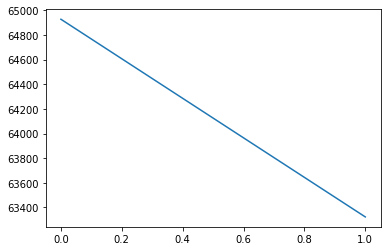

In [18]:
pd.DataFrame(history.history)["loss"].plot()

# Inference
## ScaNN
Scann is an efficient Nearest neighbor approximation to retrieve the top k product

In [19]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann.index_from_dataset(
    tf.data.Dataset.zip(
        (products_ds.map(lambda x: x["gtin"]).batch(100), products_ds.batch(100).map(model.candidate_model)))
)

Consider rewriting this model with the Functional API.


# Export result to BQ

In [20]:
step = 1000
len_queries = query_test.shape[0]
partial_result = []

for k in range(0, len_queries, step):
    sample = query_test.iloc[k:k + step, :].to_dict(orient="list")
    rec_score, rec_products = scann({
        "user_id": tf.convert_to_tensor(sample["user_id"]),
        "dow": tf.convert_to_tensor(sample["dow"]),
        "hod": tf.convert_to_tensor(sample["hod"]),
    })
    partial_result.append([rec_score.numpy(), rec_products.numpy()])

recommendation = np.concatenate([k[1] for k in partial_result], axis=0).squeeze()
recommendation = (
    pd.concat([query_test, pd.DataFrame(recommendation)], axis=1)
        .set_index(["user_id", "dow", "hod"])
        .stack()
        .reset_index()
)
recommendation.columns = ["user_id", "dow", "hod", "rank", "gtin"]
recommendation['gtin'] = recommendation['gtin'].apply(lambda x: x.decode())

recommendation

Streaming output truncated to the last 5000 lines.
        5401788, 15752571, 16617620, 13923233, 19997241,  1748148,
       22900207, 23359558,  2685191,  5433450, 20323327,  5156882,
       23722988, 19452576,  6260514, 16685857, 27075704, 24553230,
        3663611, 23008534,   217602, 16647752, 29666470,  3581491,
       20365051, 15518875,  6328152,  4289643, 33377696,  3920716,
       27748747,  1605770,  6022629, 19625389, 34976432,  6786838,
        4657818, 29815229,  6940532,  6785120,  5461867,  3505394,
       19317455, 30056708, 17139080, 32120766, 25072978, 21395396,
       26202346, 25126247, 17330707,  5053072,  2908221, 18574770,
       17200722, 16571821, 13472071, 27613538,   923448,  5439506,
       21877561,  3031306,  4333624, 13687597, 21979760, 22656163,
        4272266, 16615655,  1343499, 29661014,  1350654, 16141272,
       19837739, 14087205,  1470117, 19693534, 33370637, 16893505,
       14247016,  5375562, 18207689,  5665908, 19940416,  1216579,
        378

,user_id,dow,hod,rank,gtin
0,33574161,3,7,0,7790040126244
1,33574161,3,7,1,7622300834562
2,33574161,3,7,2,7509552861112
3,33574161,3,7,3,7794626006333
4,33574161,3,7,4,7792710000052
...,...,...,...,...,...
3565805,37192468,5,23,5,2979900002385
3565806,37192468,5,23,6,7798085681216
3565807,37192468,5,23,7,7790950142174
3565808,37192468,5,23,8,7798119220183


In [21]:
result_project_name = "peya-food-and-groceries"
result_dataset_name = "user_fiorella_dirosario"
result_table_name = "recommendation_context_model_category_6_brand_10_epoch_2"

recommendation.to_gbq(
    destination_table=f"{result_dataset_name}.{result_table_name}",
    project_id=result_project_name,
    if_exists="replace"
)

1it [00:30, 30.68s/it]


# Saving Models

In [25]:
if IN_COLAB:
    ouput_path = "/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/"  #@param ["/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/", "/content/models/", "/content/drive/MyDrive/dataton"]
else:
    ouput_path = "../models/"

path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "index_model")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(
    scann,
    path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/index_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/index_model/assets


In [26]:
query_model_path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "query_model")
if not os.path.exists(query_model_path):
    os.makedirs(query_model_path)
model.query_model.save(query_model_path)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/query_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/query_model/assets


In [27]:
candidate_model_path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "candidate_model")

if not os.path.exists(candidate_model_path):
    os.makedirs(candidate_model_path)
model.candidate_model.save(candidate_model_path)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/candidate_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/context_model_category_6_brand_10_epoch_2/candidate_model/assets
